<a href="https://colab.research.google.com/github/ziatdinovmax/GPim/blob/master/examples/notebooks/GP_based_exploration_exploitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gaussian-process based exploration-exploitation

---

This notebook demonstrates an example of GP-based exploration-exploitation in GPim on a simple toy data

---

Prepared by Maxim Ziatdinov (April 2020)

Install GPim:

In [1]:
!pip install -q git+https://github.com/ziatdinovmax/GPim

     |████████████████████████████████| 522kB 8.0MB/s 
     |████████████████████████████████| 235kB 57.6MB/s 


Imports:

In [0]:
import gpim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.random.seed(0)

In [0]:
#@title Helper functions { form-width: "10%" }
def plot_query_points(inds_all):
    inds_all = np.array(inds_all) # transform list to ndarray for plotting
    cvals = np.arange(len(inds_all))
    colorst = [cm.seismic(i) for i in np.linspace(0, 0.9, len(inds_all))]
    clrbar = np.linspace(0, len(inds_all)).reshape(-1, 1)
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
    ax1.scatter(inds_all[:, 1], inds_all[:, 0], c=cvals, cmap='seismic')
    ax1.plot(inds_all[:, 1], inds_all[:, 0])
    ax2 = fig.add_axes([.78, .1, .2, .8])
    img = plt.imshow(clrbar, cm.seismic)
    plt.gca().set_visible(False)
    clrbar_ = plt.colorbar(img, ax=ax2, orientation='vertical')
    clrbar_.set_label('Exploration steps', fontsize=14, labelpad=10)

def plot_exploration_results(func_val, gp_pred):
    for i, (func, pred) in enumerate(zip(func_val, gp_pred)):
        print('Step {}'.format(i+1))
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        ax1.imshow(func, origin='bottom')
        ax2.imshow(pred[0], origin='bottom')
        ax3.imshow(pred[1], origin='bottom')
        ax1.set_title('Input')
        ax2.set_title("GP prediction")
        ax3.set_title("Uncertainty")
        plt.show()

def mask_edges(imgdata, dist_edge):
    e1, e2 = imgdata.shape
    mask = np.ones((e1, e2)) * np.nan
    mask[dist_edge[0]:e1-dist_edge[0],
         dist_edge[1]:e2-dist_edge[1]] = 1
    return mask

Create a dummy 2D function:

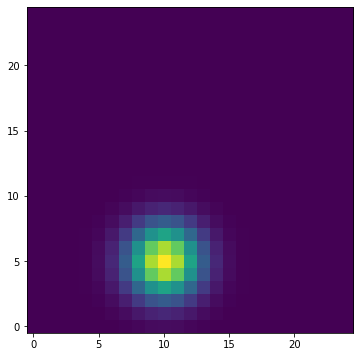

In [3]:
# Define a trial function
def trial_func(idx, **kwargs):
    """Trial function, which takes a list of indices as input"""
    x0 = kwargs.get("x0", 5)
    y0 = kwargs.get("y0", 10)
    fwhm = kwargs.get("fwhm", 4.5) 
    Z = np.exp(-4*np.log(2) * ((idx[0]-x0)**2 + (idx[1]-y0)**2) / fwhm**2) 
    return Z

# Generate grid data and calculate trial function values on a grid
x = np.arange(0, 25, 1.)
y = x[:,np.newaxis]
Z = trial_func([y, x])
# Plot
plt.figure(figsize=(6, 6))
plt.imshow(Z, origin='bottom')
plt.show()

Create sparse data (initial seed):

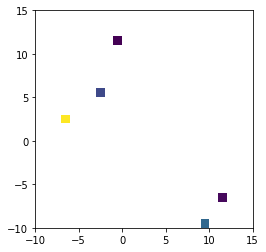

In [4]:
np.random.seed(0)
idx = np.random.randint(0, Z.shape[0], size=(2, 5))
Z_sparse = np.ones_like(Z) * np.nan
Z_sparse[idx[0], idx[1]] = Z[idx[0], idx[1]]
plt.imshow(Z_sparse, origin='bottom', extent=(-10, 15, -10, 15))

Run GP-based Bayesian optimization (BO):

In [5]:
# Get full and sparse grids
X_full = gpim.utils.get_full_grid(Z_sparse)
X_sparse= gpim.utils.get_sparse_grid(Z_sparse)
# Initialize Bayesian optimizer with an 'expected improvement' acquisition function
boptim = gpim.boptimizer(
    X_sparse, Z_sparse, X_full, 
    trial_func, acquisition_function='ei',
    exploration_steps=20,
    use_gpu=False, verbose=1)
# Run Bayesian optimization
boptim.run()


Exploration step 1 / 20
Model training...
average time per iteration: 0.0034999999999999996 s
training completed in 2.92 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.4938 12.483 ], noise: 0.0
Computing acquisition function...
Acquisition function max value 0.00043618637800445833 at [24, 24]
Model training...
average time per iteration: 0.0028000000000000004 s
training completed in 2.78 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5], noise: 0.0

Exploration step 2 / 20
Computing acquisition function...
Acquisition function max value 0.00019153401509717735 at [0, 0]
Model training...
average time per iteration: 0.003 s
training completed in 2.91 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5], noise: 0.0

Exploration step 3 / 20
Computing acquisition function...
Acquisition function max value 7.859983571074751e-05 at [24, 0]
Model training...
average time per iteration: 0.0034999999999999996 s
training completed in 3.19 s
Final parameter va

Plot input data and GP predictions at each step:

Step 1


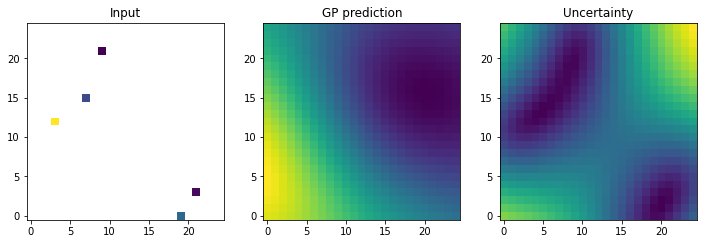

Step 2


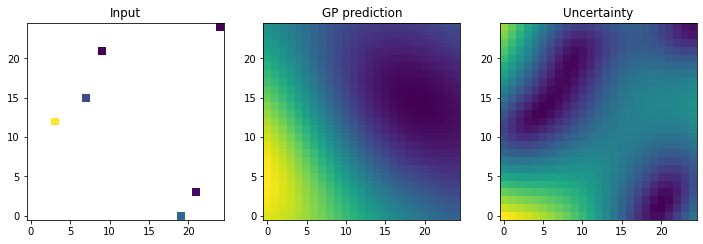

Step 3


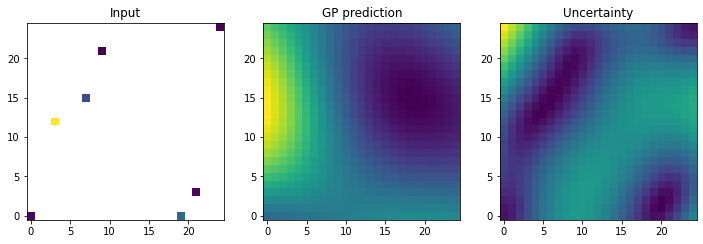

Step 4


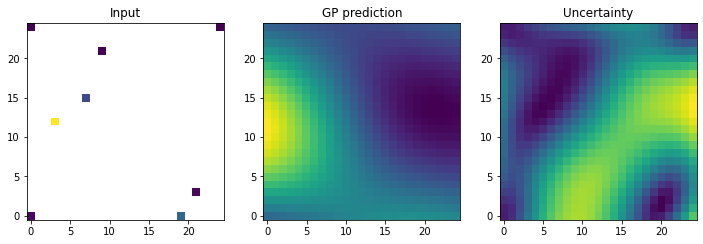

Step 5


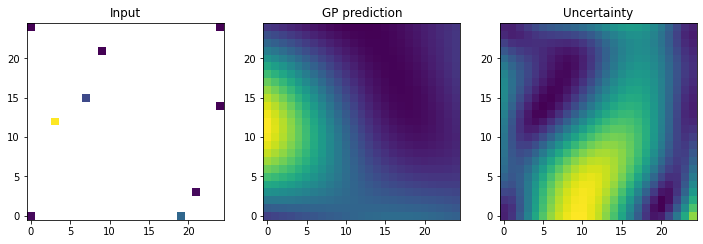

Step 6


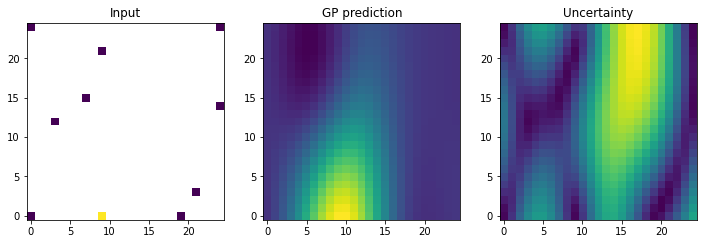

Step 7


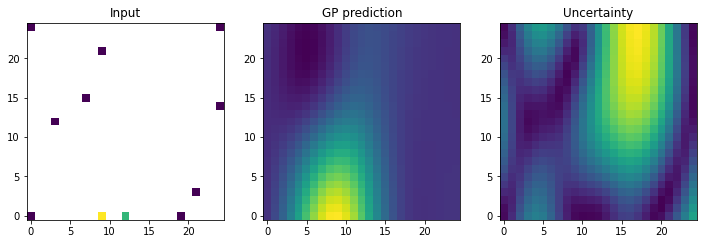

Step 8


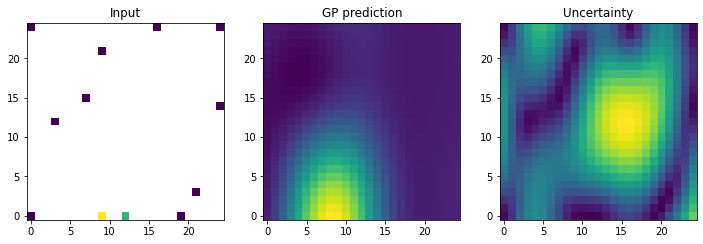

Step 9


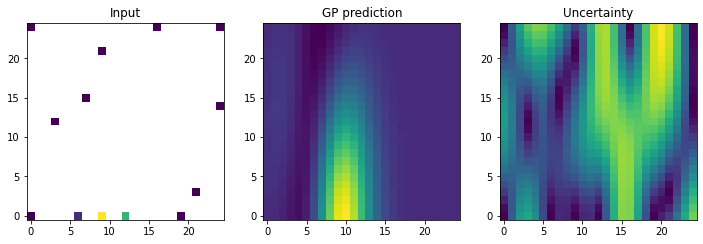

Step 10


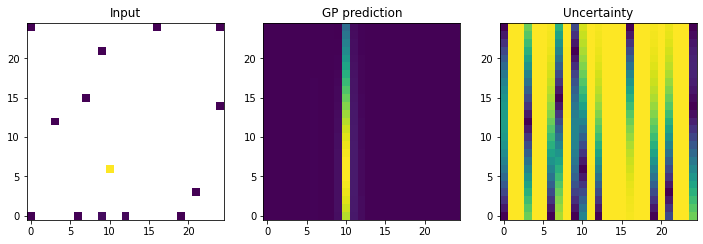

Step 11


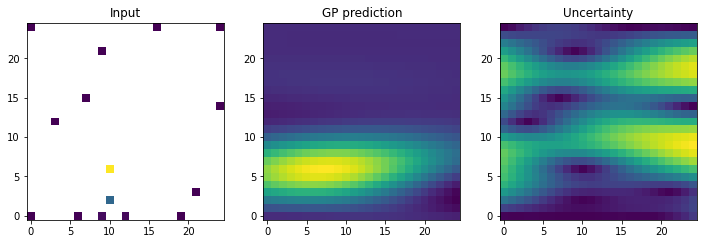

Step 12


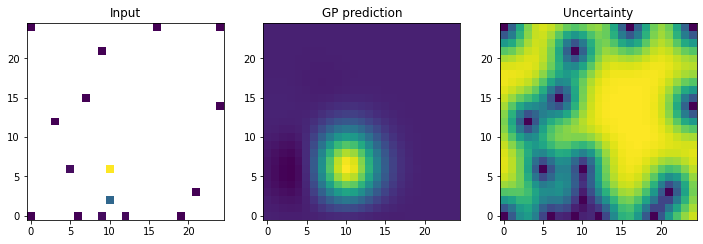

Step 13


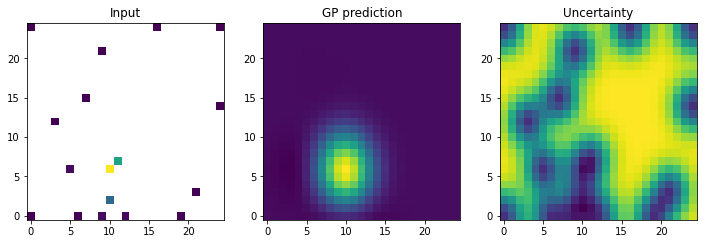

Step 14


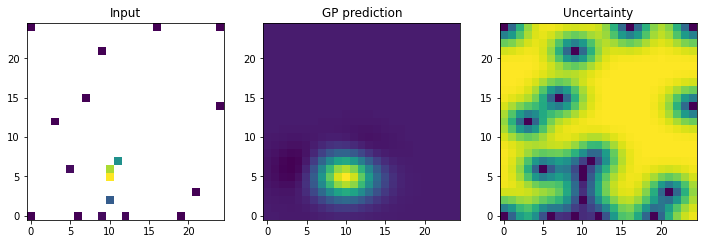

Step 15


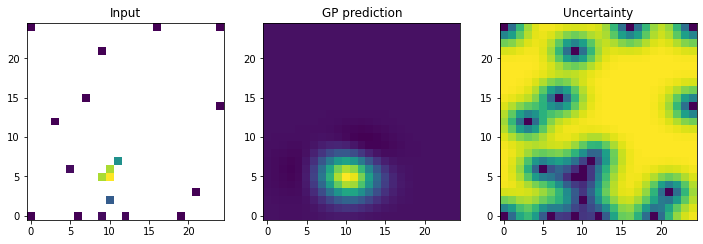

Step 16


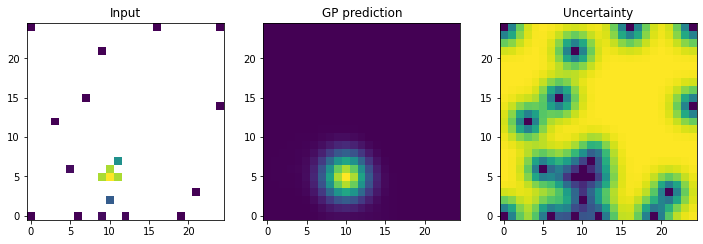

Step 17


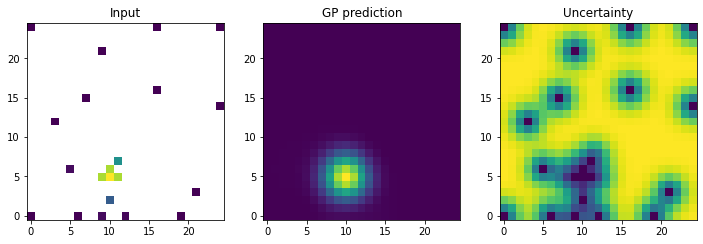

Step 18


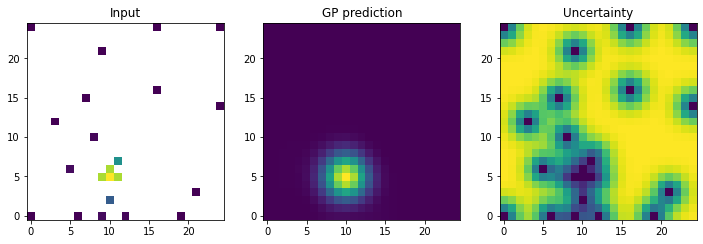

Step 19


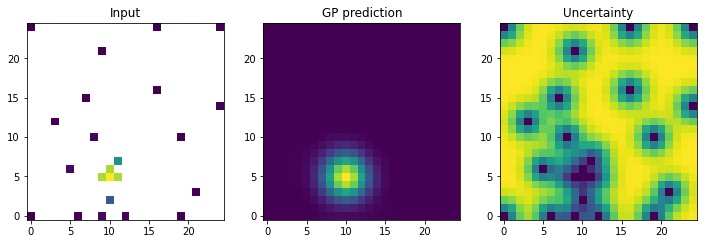

Step 20


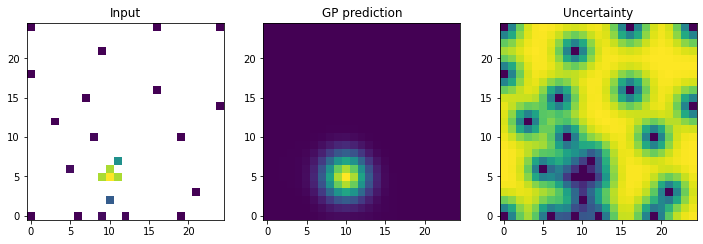

In [6]:
plot_exploration_results(boptim.target_func_vals, boptim.gp_predictions)

Plot all the query points:

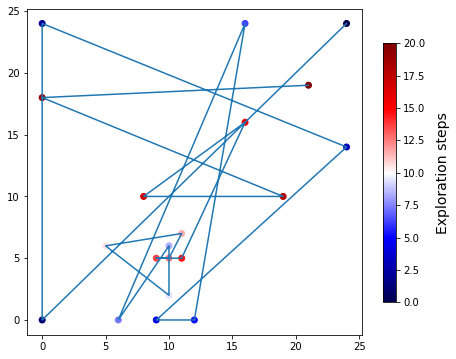

In [7]:
plot_query_points(boptim.indices_all)

Add mask (regions where the acquisition function will not be evaluated):

In [0]:
Z_mask = mask_edges(Z, (2, 2))

Same BO but with mask:

In [9]:
# Get full and sparse grids
X_full = gpim.utils.get_full_grid(Z_sparse)
X_sparse= gpim.utils.get_sparse_grid(Z_sparse)
# Initialize Bayesian optimizer with an 'expected improvement' acquisition function
boptim = gpim.boptimizer(
    X_sparse, Z_sparse, X_full, 
    trial_func, acquisition_function='ei',
    exploration_steps=20, mask=Z_mask,  # add mask
    use_gpu=False, verbose=1)
# Run Bayesian optimization
boptim.run()


Exploration step 1 / 20
Model training...
average time per iteration: 0.0029 s
training completed in 3.29 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.4938 12.483 ], noise: 0.0
Computing acquisition function...
Acquisition function max value 0.00028336203452172305 at [22, 22]
Model training...
average time per iteration: 0.003 s
training completed in 2.88 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5], noise: 0.0

Exploration step 2 / 20
Computing acquisition function...
Acquisition function max value 7.423826774404505e-05 at [2, 2]
Model training...
average time per iteration: 0.003 s
training completed in 3.1 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5], noise: 0.0

Exploration step 3 / 20
Computing acquisition function...
Acquisition function max value 6.080872698595256e-06 at [22, 2]
Model training...
average time per iteration: 0.0037 s
training completed in 3.23 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5], no

Plot input data and GP predictions at each step:

Step 1


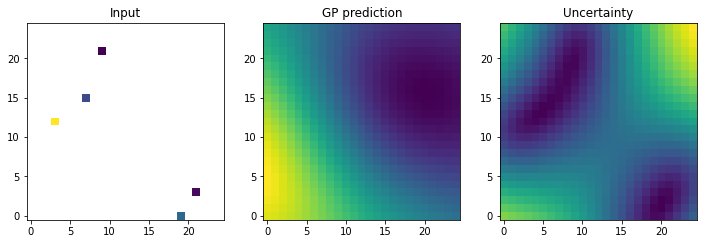

Step 2


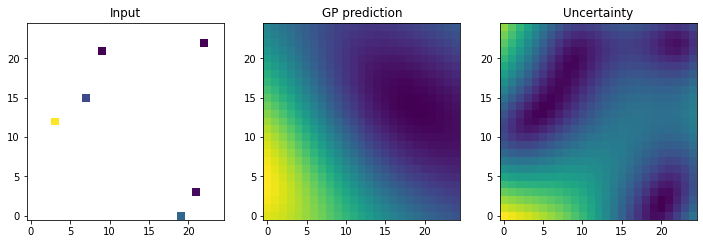

Step 3


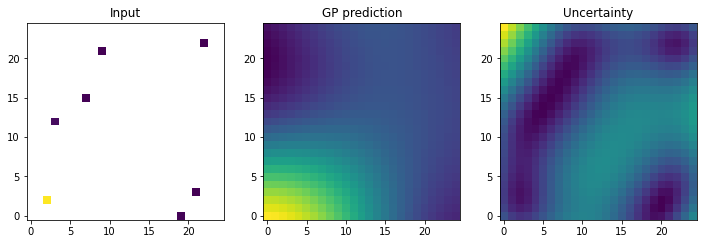

Step 4


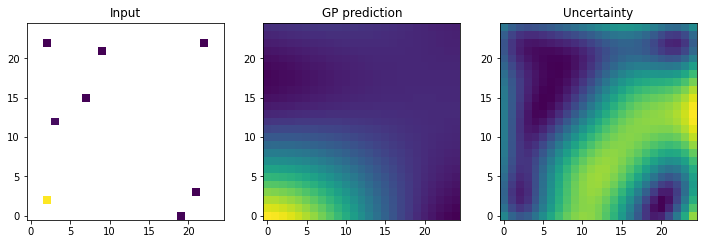

Step 5


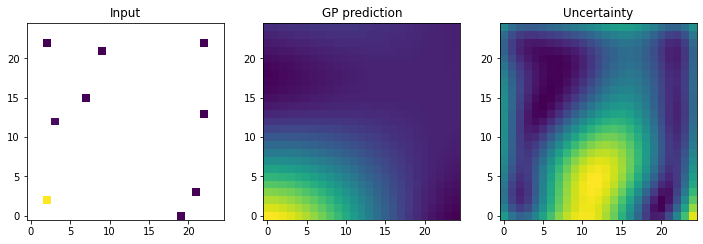

Step 6


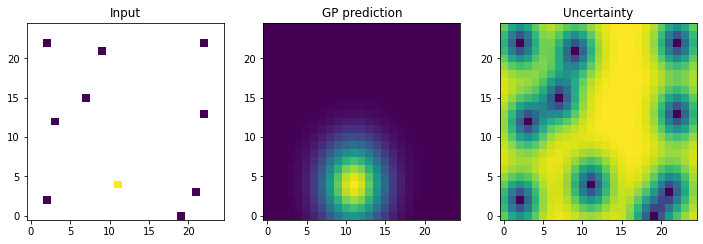

Step 7


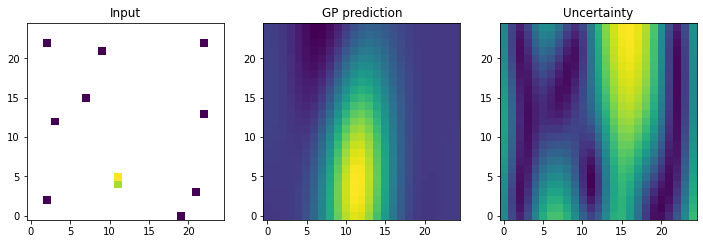

Step 8


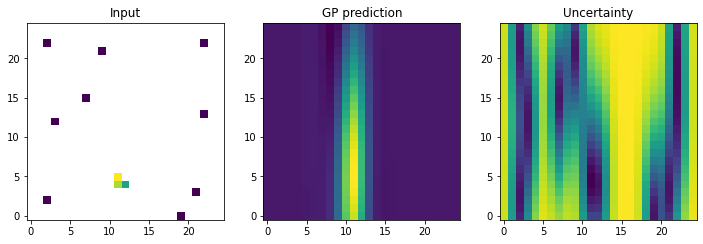

Step 9


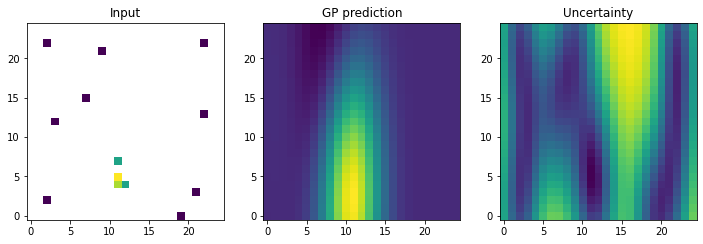

Step 10


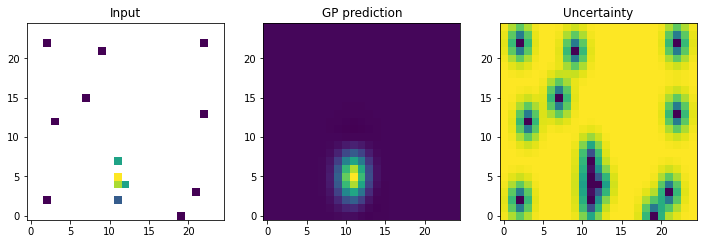

Step 11


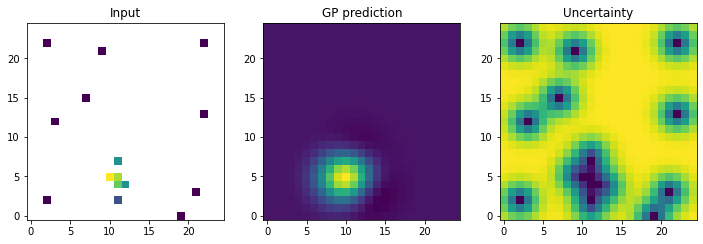

Step 12


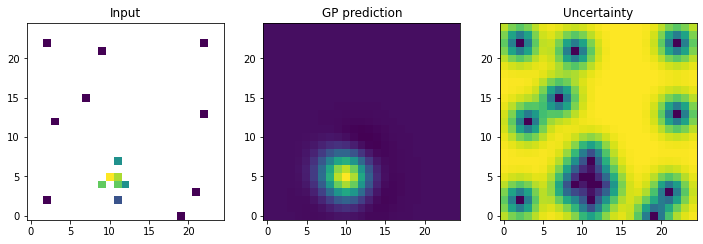

Step 13


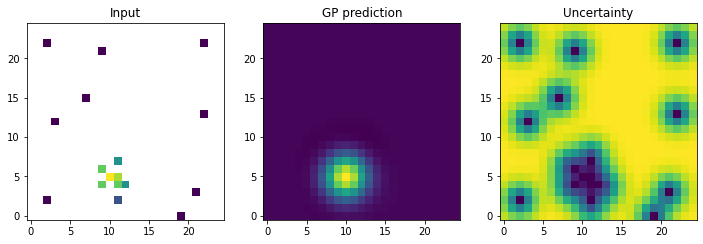

Step 14


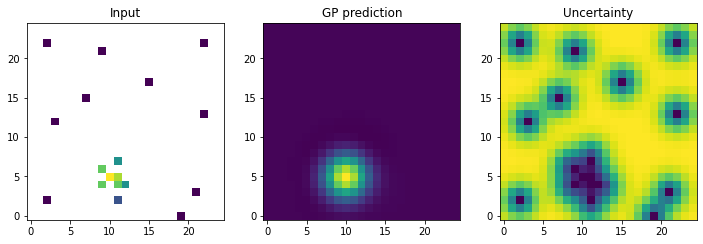

Step 15


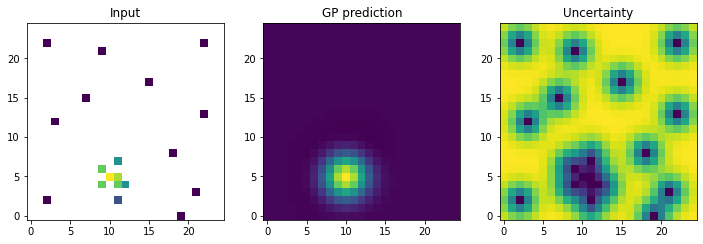

Step 16


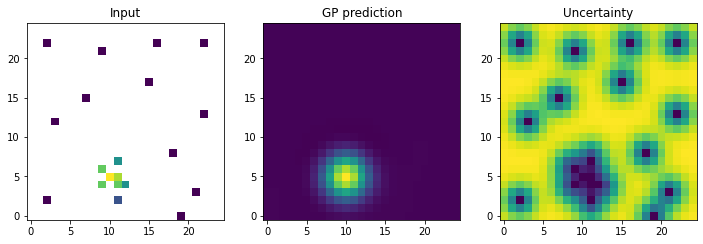

Step 17


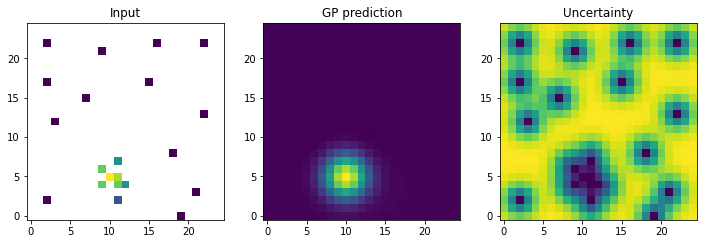

Step 18


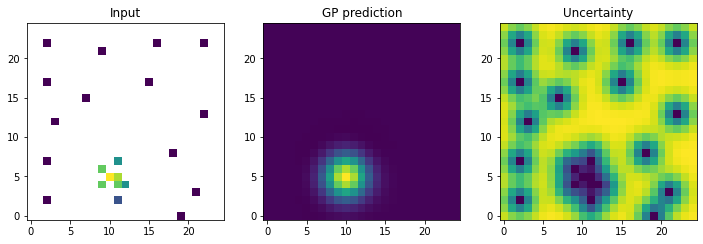

Step 19


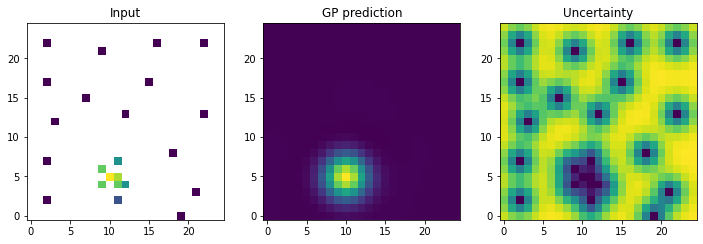

Step 20


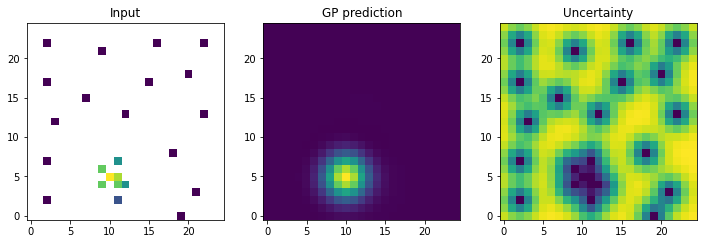

In [10]:
plot_exploration_results(boptim.target_func_vals, boptim.gp_predictions)

Plot all the query points:

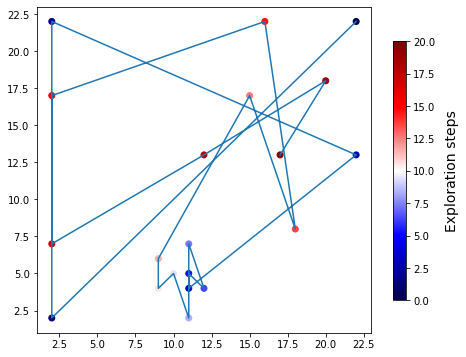

In [11]:
plot_query_points(boptim.indices_all)

Now let's add an additional criterion for selecting the next query point, which will take into the account the distance to previous points. The key parameters here are ```dscale``` (default 0), ```alpha``` (default 0.8), ```points_memory``` (default 10) and ```exit_strategy``` . (See documentation at https://gpim.readthedocs.io/en/latest/gpbayes.html for more details)

Run BO again:

In [13]:
# Get full and sparse grids
X_full = gpim.utils.get_full_grid(Z_sparse)
X_sparse= gpim.utils.get_sparse_grid(Z_sparse)
# Initialize Bayesian optimizer with an 'expected improvement' acquisition function
boptim = gpim.boptimizer(
    X_sparse, Z_sparse, X_full, 
    trial_func, acquisition_function='ei',
    exploration_steps=20, dscale=4,  # add distance-based criteria for point selection
    use_gpu=False, verbose=1)
# Run Bayesian optimization
boptim.run()


Exploration step 1 / 20
Model training...
average time per iteration: 0.0031 s
training completed in 3.02 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.4938 12.483 ], noise: 0.0
Computing acquisition function...
Acquisition function max value 0.00043618637800445833 at [24, 24]
Model training...
average time per iteration: 0.0031 s
training completed in 3.13 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5], noise: 0.0

Exploration step 2 / 20
Computing acquisition function...
Acquisition function max value 0.00019153401509717735 at [0, 0]
Model training...
average time per iteration: 0.0031 s
training completed in 2.99 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5], noise: 0.0

Exploration step 3 / 20
Computing acquisition function...
Acquisition function max value 7.859983571074751e-05 at [24, 0]
Model training...
average time per iteration: 0.0032 s
training completed in 3.12 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5]

Plot input data and GP predictions at each step:

Step 1


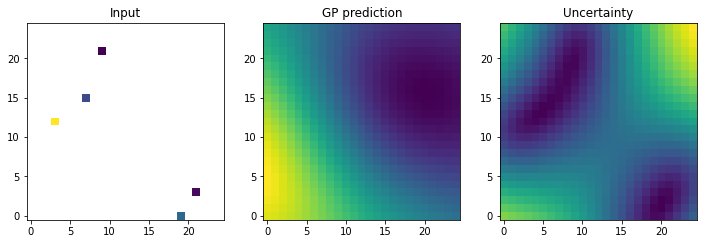

Step 2


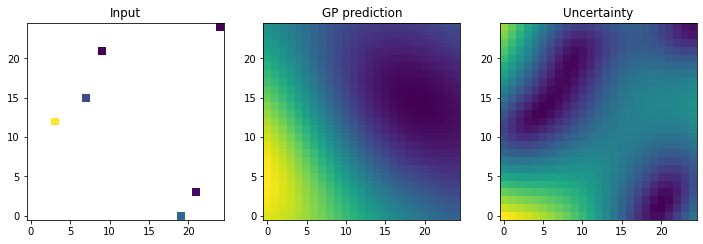

Step 3


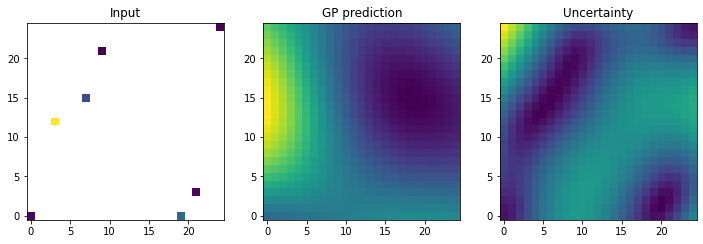

Step 4


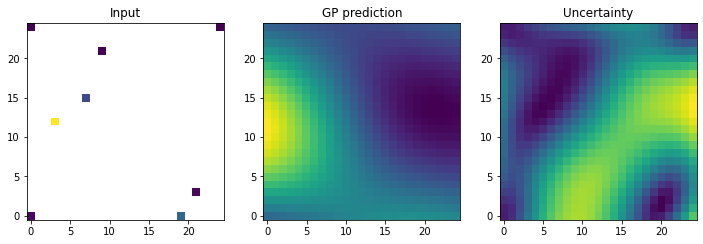

Step 5


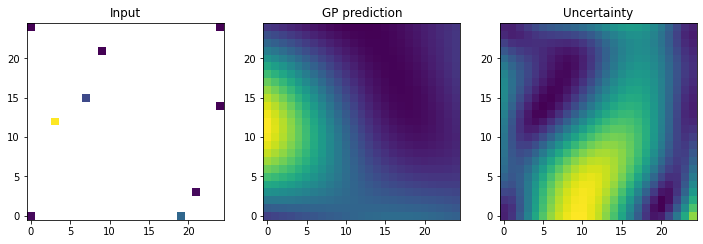

Step 6


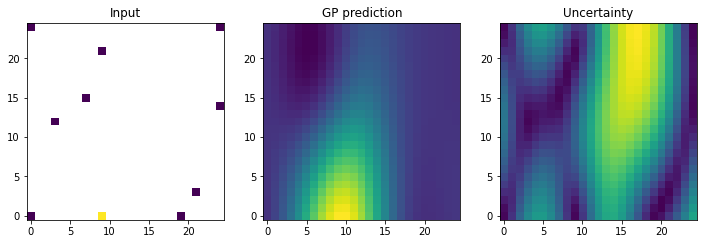

Step 7


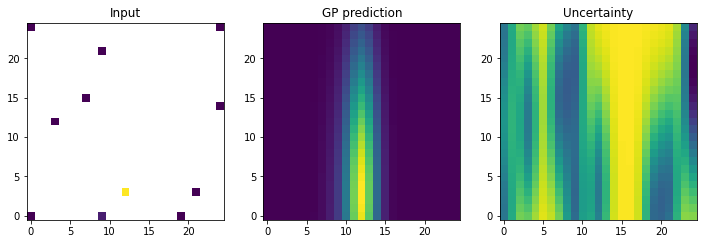

Step 8


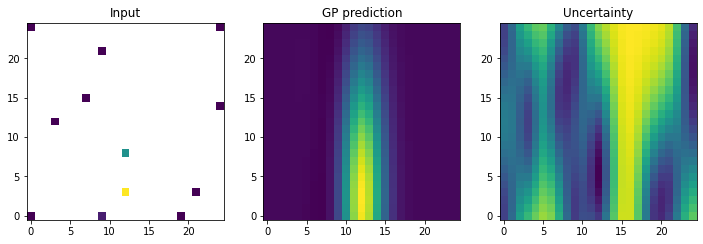

Step 9


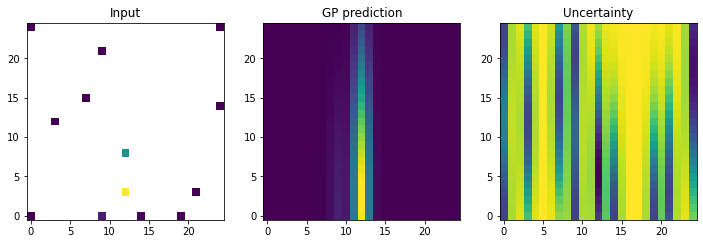

Step 10


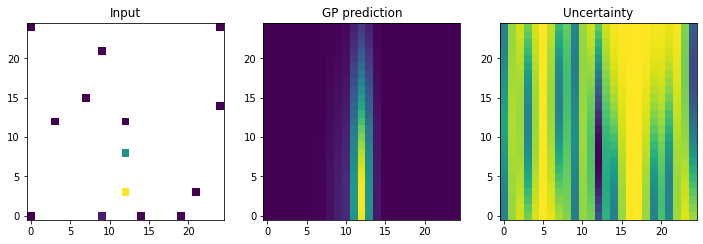

Step 11


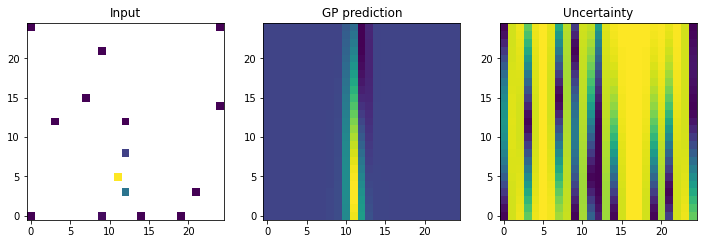

Step 12


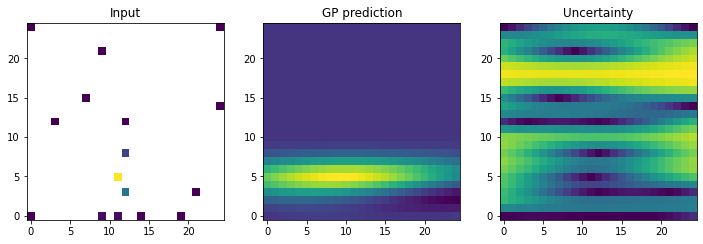

Step 13


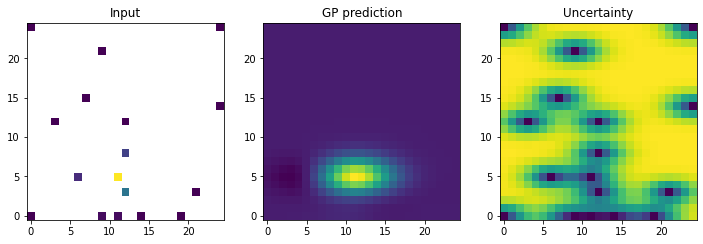

Step 14


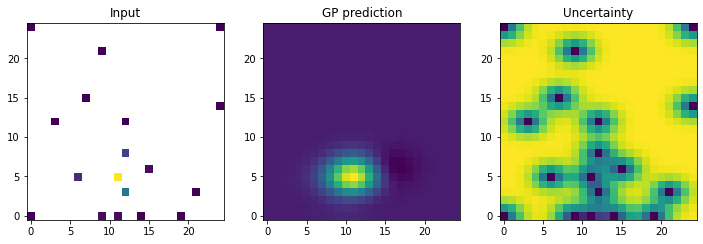

Step 15


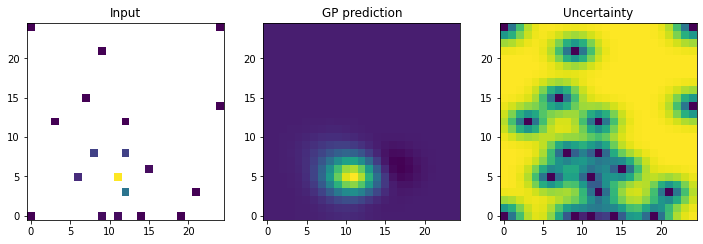

Step 16


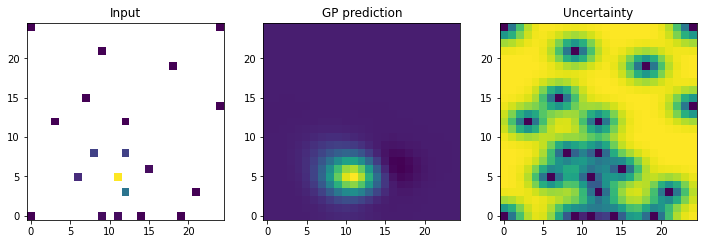

Step 17


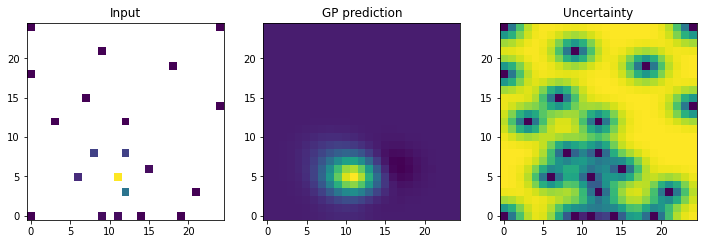

Step 18


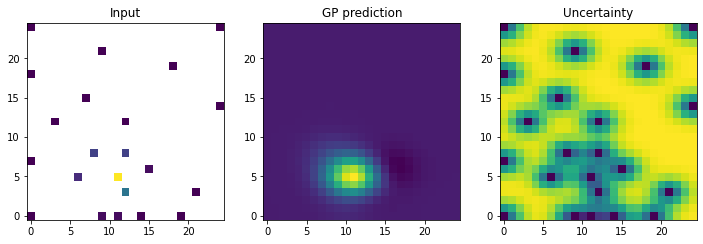

Step 19


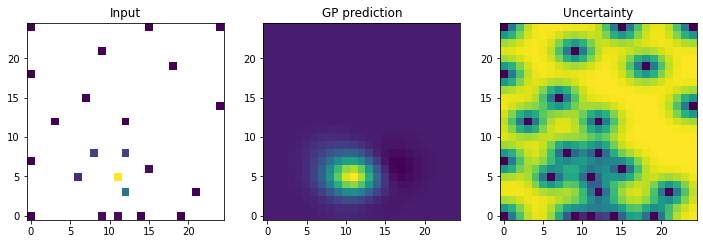

Step 20


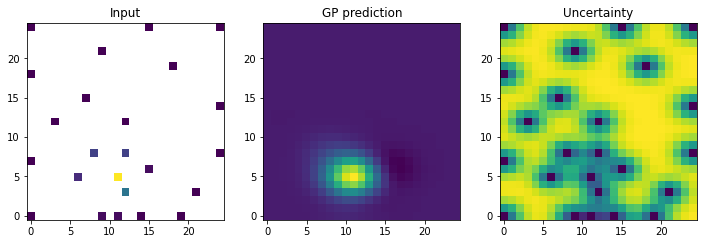

In [14]:
plot_exploration_results(boptim.target_func_vals, boptim.gp_predictions)

Plot all the query points:

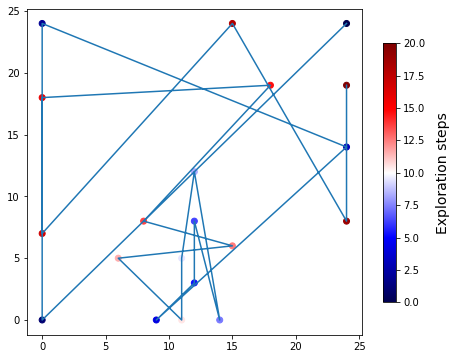

In [15]:
plot_query_points(boptim.indices_all)

Finally, we can pass our own acquistion function:

In [0]:
def acq(gpmodel, X_full, X_sparse):  # keep it as is
    mean, sd = gpmodel.predict(X_full, verbose=0) # keep it as is
    acq = 1 * mean + 5 * sd
    return acq, (mean, sd)  # keep it as is

Run BO again:

In [17]:
# Get full and sparse grids
X_full = gpim.utils.get_full_grid(Z_sparse)
X_sparse= gpim.utils.get_sparse_grid(Z_sparse)
# Initialize Bayesian optimizer with a custom acquisition function
boptim = gpim.boptimizer(
    X_sparse, Z_sparse, X_full, 
    trial_func, acquisition_function=acq,  # add custom acquisition function
    exploration_steps=20,
    use_gpu=False, verbose=1)
# Run Bayesian optimization
boptim.run()


Exploration step 1 / 20
Model training...
average time per iteration: 0.0039000000000000003 s
training completed in 3.02 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.4938 12.483 ], noise: 0.0
Computing acquisition function...
Acquisition function max value 0.040853100146398015 at [24, 24]
Model training...
average time per iteration: 0.0029 s
training completed in 3.09 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5], noise: 0.0

Exploration step 2 / 20
Computing acquisition function...
Acquisition function max value 0.033184547652410704 at [0, 0]
Model training...
average time per iteration: 0.003 s
training completed in 3.24 s
Final parameter values:
 amp: 0.0001, lengthscale: [12.5 12.5], noise: 0.0

Exploration step 3 / 20
Computing acquisition function...
Acquisition function max value 0.02773430158040047 at [24, 0]
Model training...
average time per iteration: 0.0033 s
training completed in 3.49 s
Final parameter values:
 amp: 0.0001, lengthscale: [12

Plot input data and GP predictions at each step:

Step 1


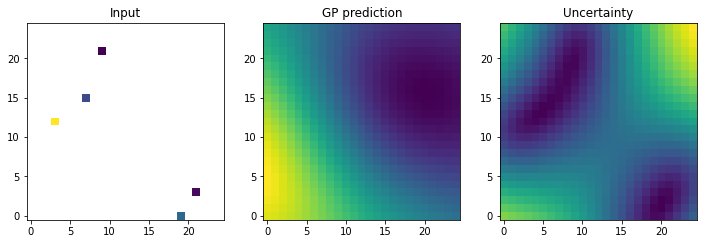

Step 2


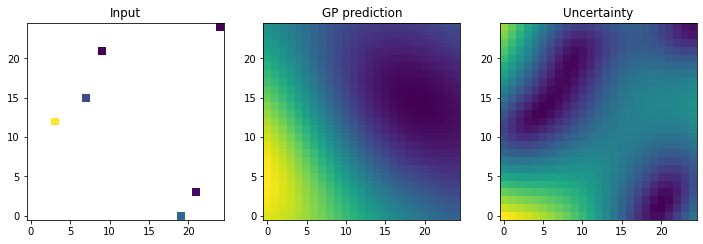

Step 3


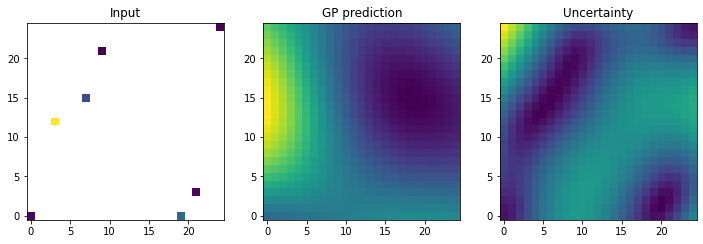

Step 4


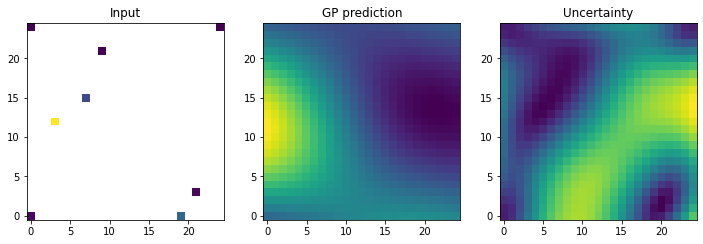

Step 5


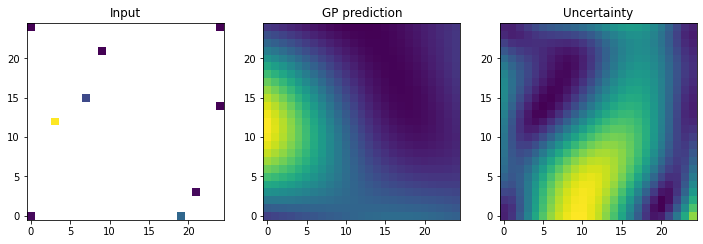

Step 6


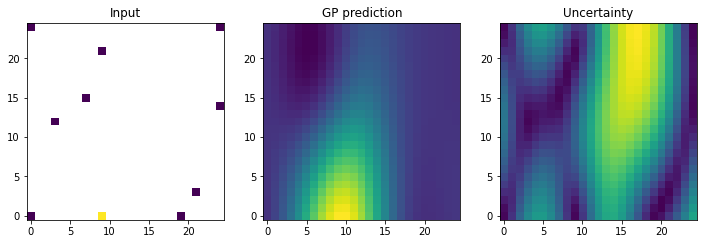

Step 7


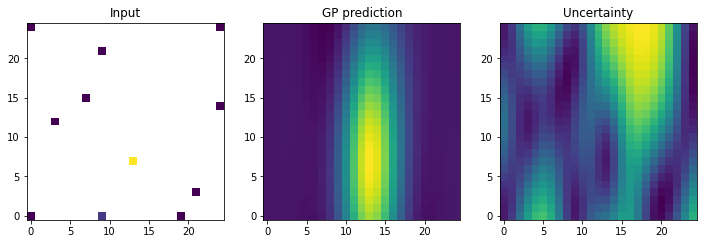

Step 8


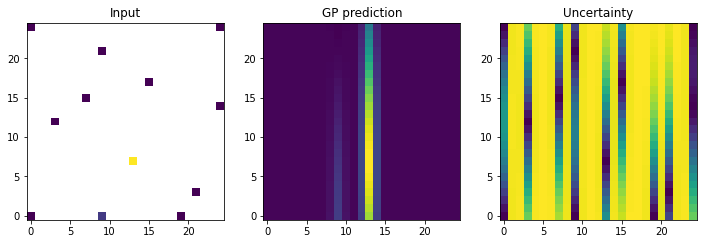

Step 9


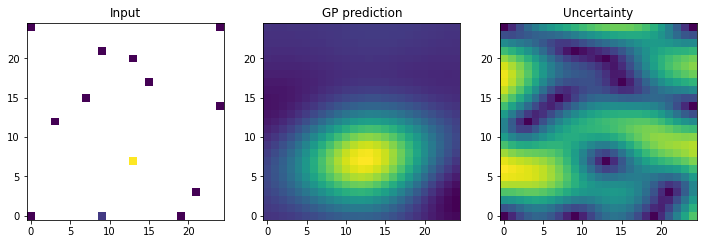

Step 10


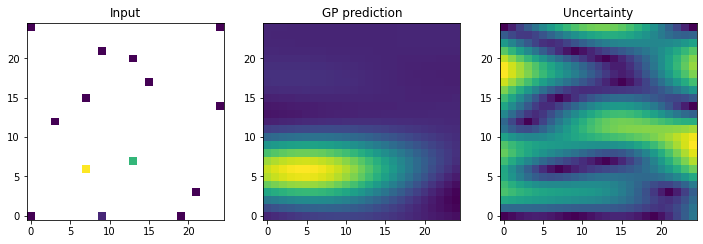

Step 11


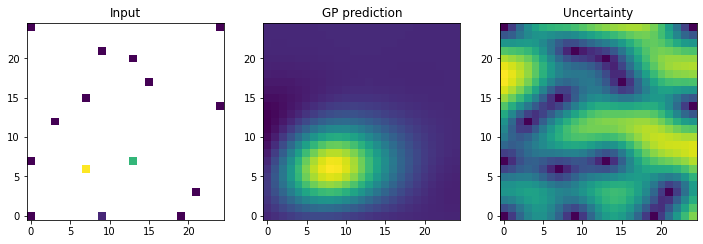

Step 12


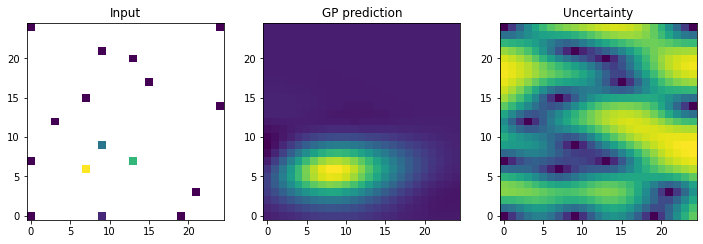

Step 13


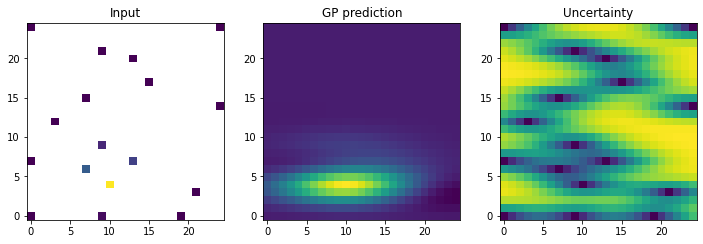

Step 14


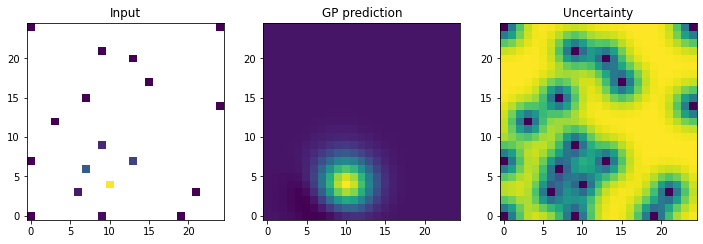

Step 15


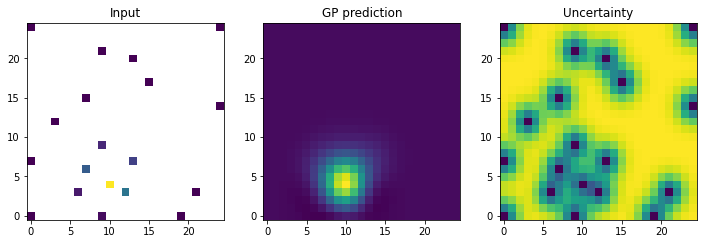

Step 16


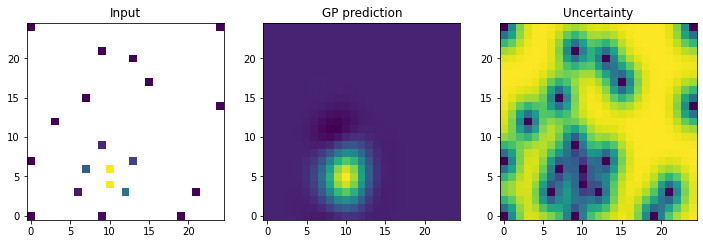

Step 17


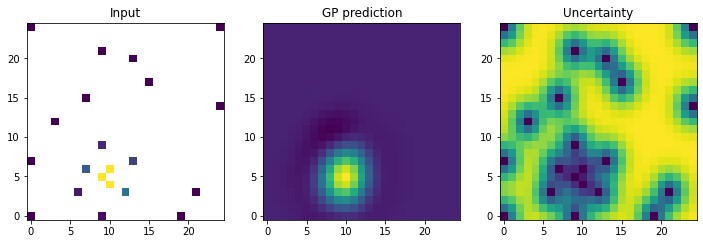

Step 18


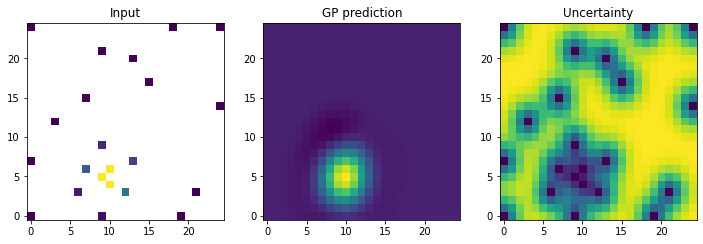

Step 19


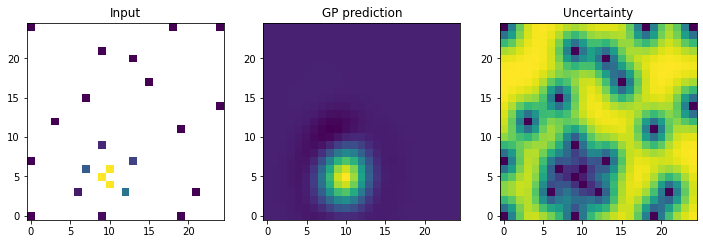

Step 20


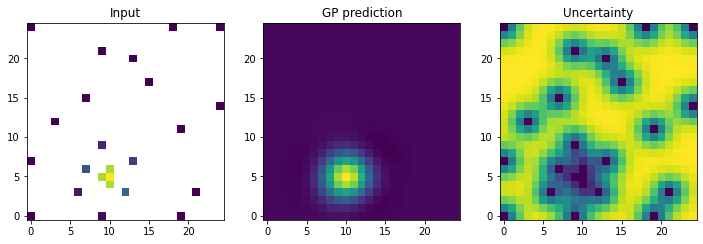

In [18]:
plot_exploration_results(boptim.target_func_vals, boptim.gp_predictions)

Plot all the query points:

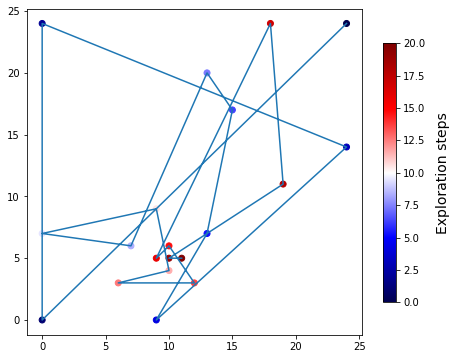

In [19]:
plot_query_points(boptim.indices_all)